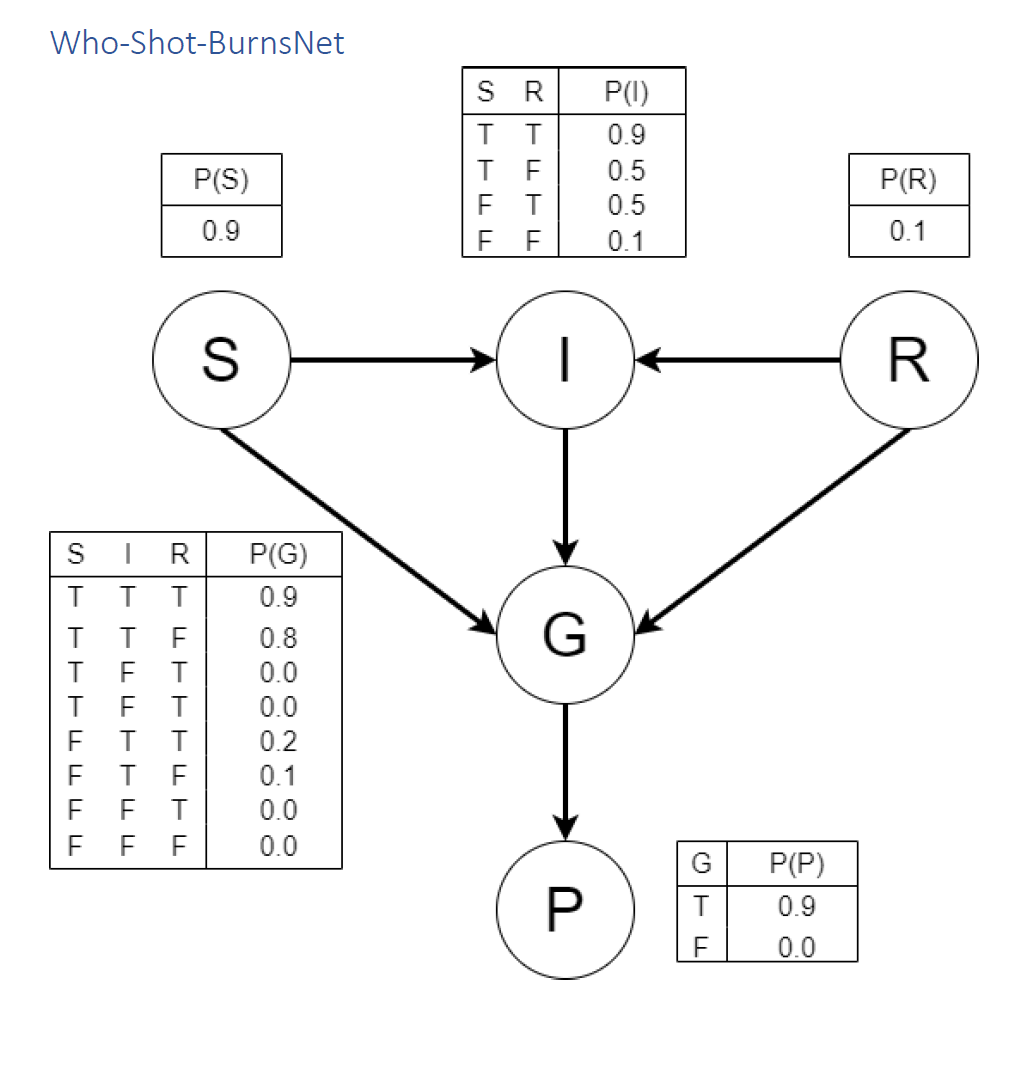

Mr. Burns has been shot and someone in Springfield is guilty. Following the evidence, Lisa comes up with a suspect with about a 90% confidence they did it. There is a 10% chance that the suspect is a rival to the prosecutor which gives them more incentive to indict and prosecute. If found guilty, they go to Springfield Prison. Using the Bayesian Network and CPTs outlined below, use the BayesNet program we coded in class to answer the questions below.

Code for the Classes:

In [1]:
from collections import defaultdict, Counter
import itertools
import math
import random

class BayesNet(object):
    "Bayesian network: a graph of variables connected by parent links."
     
    def __init__(self): 
        self.variables = [] # List of variables, in parent-first topological sort order
        self.lookup = {}    # Mapping of {variable_name: variable} pairs
            
    def add(self, name, parentnames, cpt):
        "Add a new Variable to the BayesNet. Parentnames must have been added previously."
        parents = [self.lookup[name] for name in parentnames]
        var = Variable(name, cpt, parents)
        self.variables.append(var)
        self.lookup[name] = var
        return self
    
class Variable(object):
    "A discrete random variable; conditional on zero or more parent Variables."
    
    def __init__(self, name, cpt, parents=()):
        "A variable has a name, list of parent variables, and a Conditional Probability Table."
        self.__name__ = name
        self.parents  = parents
        self.cpt      = CPTable(cpt, parents)
        self.domain   = set(itertools.chain(*self.cpt.values())) # All the outcomes in the CPT
                
    def __repr__(self): return self.__name__
    
class Factor(dict): "An {outcome: frequency} mapping."

class ProbDist(Factor):
    """A Probability Distribution is an {outcome: probability} mapping. 
    The values are normalized to sum to 1.
    ProbDist(0.75) is an abbreviation for ProbDist({T: 0.75, F: 0.25})."""
    def __init__(self, mapping=(), **kwargs):
        if isinstance(mapping, float):
            mapping = {T: mapping, F: 1 - mapping}
        self.update(mapping, **kwargs)
        normalize(self)
        
class Evidence(dict): 
    "A {variable: value} mapping, describing what we know for sure."
        
class CPTable(dict):
    "A mapping of {row: ProbDist, ...} where each row is a tuple of values of the parent variables."
    
    def __init__(self, mapping, parents=()):
        """Provides two shortcuts for writing a Conditional Probability Table. 
        With no parents, CPTable(dist) means CPTable({(): dist}).
        With one parent, CPTable({val: dist,...}) means CPTable({(val,): dist,...})."""
        if len(parents) == 0 and not (isinstance(mapping, dict) and set(mapping.keys()) == {()}):
            mapping = {(): mapping}
        for (row, dist) in mapping.items():
            if len(parents) == 1 and not isinstance(row, tuple): 
                row = (row,)
            self[row] = ProbDist(dist)

class Bool(int):
    "Just like `bool`, except values display as 'T' and 'F' instead of 'True' and 'False'"
    __str__ = __repr__ = lambda self: 'T' if self else 'F'
        
T = Bool(True)
F = Bool(False)


Let's write up some associated functions like the probability distribution function, a normalization function and a sample function:

In [2]:
def P(var, evidence={}):
    "The probability distribution for P(variable | evidence), when all parent variables are known (in evidence)."
    row = tuple(evidence[parent] for parent in var.parents) # creates variables based on evidence
    return var.cpt[row]

def normalize(dist):
    "Normalize a {key: value} distribution so values sum to 1.0. Mutates dist and returns it."
    total = sum(dist.values())
    for key in dist:
        dist[key] = dist[key] / total
        assert 0 <= dist[key] <= 1, "Probabilities must be between 0 and 1"
    return dist

def sample(probdist):
    "Randomly sample an outcome from a probability distribution."
    r = random.random() #r is a random point in the probability distribution
    c = 0.0             # c is the cumulative probability of the outcomes we have seen so far
    for outcome in probdist:
        c += probdist[outcome]
        if r <= c:
            return outcome
        
def globalize(mapping):
    "Given a {name: value} mapping, export all the names to the `globals()` namespace."
    globals().update(mapping)

Now Define Bayes net using diagram above

In [3]:
# Define Who Shot Burns Net using the BayesNet class
burns_net = (BayesNet()
         .add('Suspect', [], 0.9)
         .add('Rival', [], 0.1)
         .add('Incentive', ['Suspect', 'Rival'], {(T, T): 0.9, (T, F): 0.5, (F,T): 0.5, (F, F): 0.1})
         .add('Guilty', ['Suspect', 'Incentive', 'Rival'], {(T, T, T): 0.9, (T,T,F): 0.8, (T,F,T): 0.0, (T,F,F): 0.0,
                                     (F,T,T): 0.2, (F,T,F): 0.1, (F,F,T): 0.0, (F,F,F): 0.0})
         .add('Prison', ['Guilty'], {T: 0.9, F:0.0}) )

Globalize burns_net

In [4]:
# Make S, R, I, G, P be global variables
globalize(burns_net.lookup)
burns_net.variables

[Suspect, Rival, Incentive, Guilty, Prison]

Joint Probability Distributions

In [5]:
def joint_distribution(net):
    "Given a Bayes net, create the joint distribution over all variables."
    return ProbDist({row: prod(P_xi_given_parents(var, row, net)
                               for var in net.variables)
                                for row in all_rows(net)})



def all_rows(net): 
    "Returns all joint distribution rows"
    return itertools.product(*[var.domain for var in net.variables])


def P_xi_given_parents(var, row, net):
    "The probability that var = xi, given the values in this row."
    dist = P(var, Evidence(zip(net.variables, row)))
    xi = row[net.variables.index(var)]
    return dist[xi]


def prod(numbers):
    "The product of numbers: prod([2, 3, 5]) == 30. Analogous to `sum([2, 3, 5]) == 10`."
    result = 1
    for x in numbers:
        result *= x
    return result


Inference by Querying the Join Distribution

In [11]:
def enumeration_ask(X, evidence, net):
    "The probability distribution for query variable X in a belief net, given evidence."
    i = net.variables.index(X) # the index of the query variable X in the row
    dist = defaultdict(float) # resulting probability distribution over X
    for(row, p) in joint_distribution(net).items():
        if matches_evidence(row, evidence, net):
            dist[row[i]] += p
    return ProbDist(dist)


def matches_evidence(row, evidence, net):
    "Does the tuple of values for this row agree with the evidence?"
    return all(row[net.variables.index(v)] == evidence[v] for v in evidence)

# Questions #

1. calculate the value of P(S, I, R, ~G, P)

In [7]:

# Probabilty of going to prison if they're a suspect, been indicted, a rival, but not guilty
P(Prison, {Suspect: T, Incentive: T, Rival: T, Guilty: F})[T]



0.0

2. calculate the value of P(S, I, ~R, G, P)

In [8]:
P(Prison, {Suspect: T, Incentive: T, Rival: F, Guilty: T})[T]

0.9

3. What is the probability of Lisa’s suspect going to prison if they actually shot Burns and been indicted and are also a rival of the prosecutor?

In [13]:

#probability of prison given they were guilty and indicted and a rival of the prosecutor

enumeration_ask(Prison, {Guilty: T, Incentive: T, Rival: T}, burns_net)[T]


0.8999999999999999

4. What is the probability of Lisa’s suspect going to prison if they didn’t shoot burns but had a rival prosecutor?

In [14]:
# probability of prison given they're not guilty but had a rival prosecutor

enumeration_ask(Prison, {Guilty: F, Rival: T}, burns_net)[T]

0.0